#### CSC 180-01 Intelligent Systems (Fall 2022)
##### Group: Jonathan Jakab,  Jacob Hallum, Mahdi Noureddine
##### California State University, Sacramento

# Project 1: Yelp Business Rating Prediction using Tensorflow

### Used to allocate a specific amount of memory to GPU.
#### Note: Can not be reinitialized once the program is running. Chose VRAM amount before as MB
##### tf.config.LogicalDeviceConfiguration(memory_limit=16384) <----

In [1]:
# Used to test GPU support
import tensorflow as tf

#Checks if GPU is available and prints physical devices
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# tf.config.list_physical_devices('GPU')

# Sets max GPU memory usage
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only allocate 10GB of memory on the first GPU
    try:
        tf.config.set_logical_device_configuration(gpus[0], [tf.config.LogicalDeviceConfiguration(memory_limit=10240)])
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


# Imports
Contains the imports for the applications. 

In [2]:
import os
import csv
import json
import shutil
import numpy as np
import pandas as pd

from collections.abc import Sequence

import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import sklearn.feature_extraction.text as sk_text

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

# Helpful Functions for Tensorflow (from Labs)

The following functions will be used with TensorFlow to help preprocess the data.  They allow you to build the feature vector for a neural network. 

* Predictors/Inputs 
    * Fill any missing inputs with the median for that column.  Use **missing_median**.
    * Encode textual/categorical values with **encode_text_dummy**.
    * Encode numeric values with **encode_numeric_zscore**.
* Output
    * Discard rows with missing outputs.
    * Encode textual/categorical values with **encode_text_index**.
    * Do not encode output numeric values.
* Produce final feature vectors (x) and expected output (y) with **to_xy**.

In [3]:
# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

    
# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

    
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.xlabel('business')
    plt.legend()
    plt.show()

    
# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low    

# Input/Output Setup
* ***Checks directories for Data input and output***
* ***Reads in data from the review file in the data directory***

In [4]:
# Get current working directory
current_directory = os.getcwd()


# Sets up input file locations for the data input.
dataPath = "./data/"
dataDirectory = os.path.join(current_directory, dataPath)
inputFile_Review = os.path.join(dataPath,"yelp_academic_dataset_review.json")
inputFile_Business = os.path.join(dataPath,"yelp_academic_dataset_business.json")


# Sets up locations for the data output location.
savePath = "./output/"
saveDirectory = os.path.join(current_directory, savePath)

if os.path.exists(saveDirectory):
    outputFile_Review = os.path.join(savePath,"review_stars.tsv")
    outputFile_Business = os.path.join(savePath,"review_business.tsv")
else:
    os.makedirs(saveDirectory)
    outputFile_Review = os.path.join(savePath,"review_stars.tsv")
    outputFile_Business = os.path.join(savePath,"review_business.tsv")

# Data Processing
### Read in reviews from yelp_academic_dataset_review.JSON

In [5]:
# Opens output files and loads data from input file.
outfile = open(outputFile_Review, 'w')
sfile = csv.writer(outfile, delimiter ="\t", quoting=csv.QUOTE_MINIMAL)
sfile.writerow(['business_id','stars', 'text'])

with open(inputFile_Review, encoding="utf-8") as f:
    for line in f:
        row = json.loads(line)
        # some special char must be encoded in 'utf-8'
        sfile.writerow([row['business_id'], row['stars'], (row['text']).encode('utf-8')])
outfile.close()

df_review = pd.read_csv(outputFile_Review, delimiter ="\t", encoding="utf-8")
df_review


,business_id,stars,text
0,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,"b""If you decide to eat here, just be aware it ..."
1,7ATYjTIgM3jUlt4UM3IypQ,5.0,"b""I've taken a lot of spin classes over the ye..."
2,YjUWPpI6HXG530lwP-fb2A,3.0,b'Family diner. Had the buffet. Eclectic assor...
3,kxX2SOes4o-D3ZQBkiMRfA,5.0,"b""Wow! Yummy, different, delicious. Our fa..."
4,e4Vwtrqf-wpJfwesgvdgxQ,4.0,"b""Cute interior and owner (?) gave us tour of ..."
...,...,...,...
6990275,jals67o91gcrD4DC81Vk6w,5.0,b'Latest addition to services from ICCU is App...
6990276,2vLksaMmSEcGbjI5gywpZA,5.0,"b""This spot offers a great, affordable east we..."
6990277,R1khUUxidqfaJmcpmGd4aw,4.0,"b""This Home Depot won me over when I needed to..."
6990278,Rr9kKArrMhSLVE9a53q-aA,5.0,b'For when I\'m feeling like ignoring my calor...


### Read in businesses from yelp_academic_dataset_business.JSON

In [6]:
# Opens output files and loads data from input file.
outfile = open(outputFile_Business, 'w')
sfile = csv.writer(outfile, delimiter ="\t", quoting=csv.QUOTE_MINIMAL)
sfile.writerow(['business_id','name', 'stars', 'review_count', 'categories'])

with open(inputFile_Business, encoding="utf-8") as f:
    for line in f:
        row = json.loads(line)
        # some special char must be encoded in 'utf-8'
        sfile.writerow([row['business_id'], row['name'].encode('utf-8'), row['stars'], row['review_count'], (row['categories'])])
outfile.close()

df_business = pd.read_csv(outputFile_Business, delimiter ="\t", encoding="utf-8")
df_business

,business_id,name,stars,review_count,categories
0,Pns2l4eNsfO8kk83dixA6A,"b'Abby Rappoport, LAC, CMQ'",5.0,7,"Doctors, Traditional Chinese Medicine, Naturop..."
1,mpf3x-BjTdTEA3yCZrAYPw,b'The UPS Store',3.0,15,"Shipping Centers, Local Services, Notaries, Ma..."
2,tUFrWirKiKi_TAnsVWINQQ,b'Target',3.5,22,"Department Stores, Shopping, Fashion, Home & G..."
3,MTSW4McQd7CbVtyjqoe9mw,b'St Honore Pastries',4.0,80,"Restaurants, Food, Bubble Tea, Coffee & Tea, B..."
4,mWMc6_wTdE0EUBKIGXDVfA,b'Perkiomen Valley Brewery',4.5,13,"Brewpubs, Breweries, Food"
...,...,...,...,...,...
150341,IUQopTMmYQG-qRtBk-8QnA,"b""Binh's Nails""",3.0,13,"Nail Salons, Beauty & Spas"
150342,c8GjPIOTGVmIemT7j5_SyQ,b'Wild Birds Unlimited',4.0,5,"Pets, Nurseries & Gardening, Pet Stores, Hobby..."
150343,_QAMST-NrQobXduilWEqSw,"b""Claire's Boutique""",3.5,8,"Shopping, Jewelry, Piercing, Toy Stores, Beaut..."
150344,mtGm22y5c2UHNXDFAjaPNw,b'Cyclery & Fitness Center',4.0,24,"Fitness/Exercise Equipment, Eyewear & Optician..."


### Clean up records. (Remove all businesses that have fewer then 20 reviews.)

In [7]:
df_business_cleaned = df_business[df_business["review_count"] >= 20]
df_business_cleaned

,business_id,name,stars,review_count,categories
2,tUFrWirKiKi_TAnsVWINQQ,b'Target',3.5,22,"Department Stores, Shopping, Fashion, Home & G..."
3,MTSW4McQd7CbVtyjqoe9mw,b'St Honore Pastries',4.0,80,"Restaurants, Food, Bubble Tea, Coffee & Tea, B..."
12,il_Ro8jwPlHresjw9EGmBg,"b""Denny's""",2.5,28,"American (Traditional), Restaurants, Diners, B..."
14,0bPLkL0QhhPO5kt1_EXmNQ,"b""Zio's Italian Market""",4.5,100,"Food, Delis, Italian, Bakeries, Restaurants"
15,MUTTqe8uqyMdBl186RmNeA,b'Tuna Bar',4.0,245,"Sushi Bars, Restaurants, Japanese"
...,...,...,...,...,...
150330,GeEveoOaU2YKD7jJtEfA_g,b'DeVons Jewelers',5.0,34,"Shopping, Watches, Jewelry"
150331,qQ7FHvkGEMqoPKKXPk4gjA,b'La Quinta by Wyndham NW Tucson Marana',2.5,67,"Hotels & Travel, Hotels, Event Planning & Serv..."
150334,LJ4GjQ1HL6kqvIPpNUNNaQ,b'Shanti Yoga and Ayurveda',4.5,39,"Health & Medical, Yoga, Shopping, Naturopathic..."
150336,WnT9NIzQgLlILjPT0kEcsQ,b'Adelita Taqueria & Restaurant',4.5,35,"Restaurants, Mexican"


### Group reviews and businesses into a new Dataframe. (Reviews are aggregated together for each business entry.)

In [8]:
df_review_agg = df_review.groupby('business_id')['text'].sum()
df_review_agg_new = pd.DataFrame({'business_id': df_review_agg.index, 'all_reviews': df_review_agg.values})
df_review_agg_new

,business_id,all_reviews
0,---kPU91CF4Lq2-WlRu9Lw,"b""Ate here for the 1st time on Saturday 08/07/..."
1,--0iUa4sNDFiZFrAdIWhZQ,"b""Very good San Salvadorian place ! Authentic ..."
2,--30_8IhuyMHbSOcNWd6DQ,"b""We stopped going to Action Karate in Decembe..."
3,--7PUidqRWpRSpXebiyxTg,"b'This place is disgusting, and proof that Edm..."
4,--7jw19RH9JKXgFohspgQw,"b'This is the best dentist in the area, hands ..."
...,...,...
150341,zznZqH9CiAznbkV6fXyHWA,"b""Oh my gosh! Yum yum yum! I saw Que Pasta sta..."
150342,zztOG2cKm87I6Iw_tleZsQ,b'This course is exactly what I needed to get ...
150343,zzu6_r3DxBJuXcjnOYVdTw,"b""Probably the best Italian food on the Westba..."
150344,zzw66H6hVjXQEt0Js3Mo4A,b'Went to the Ballwin location this year. The...


### Merge tables
Merge the cleaned up business table with the aggregated reviews file to make one file that contains all the businesses and reviews.

In [9]:
df_ready_for_sklearn = pd.merge(df_business_cleaned, df_review_agg_new, on='business_id')
df_ready_for_sklearn

,business_id,name,stars,review_count,categories,all_reviews
0,tUFrWirKiKi_TAnsVWINQQ,b'Target',3.5,22,"Department Stores, Shopping, Fashion, Home & G...",b'We are fans of Target. They seem to have a ...
1,MTSW4McQd7CbVtyjqoe9mw,b'St Honore Pastries',4.0,80,"Restaurants, Food, Bubble Tea, Coffee & Tea, B...","b""This is nice little Chinese bakery in the he..."
2,il_Ro8jwPlHresjw9EGmBg,"b""Denny's""",2.5,28,"American (Traditional), Restaurants, Diners, B...",b'Went there at 4am and there was only one wai...
3,0bPLkL0QhhPO5kt1_EXmNQ,"b""Zio's Italian Market""",4.5,100,"Food, Delis, Italian, Bakeries, Restaurants","b""The worst Chicken Parm. Sandwich I've ever e..."
4,MUTTqe8uqyMdBl186RmNeA,b'Tuna Bar',4.0,245,"Sushi Bars, Restaurants, Japanese",b'Stopped in to check out this new spot around...
...,...,...,...,...,...,...
61914,GeEveoOaU2YKD7jJtEfA_g,b'DeVons Jewelers',5.0,34,"Shopping, Watches, Jewelry","b'After buying my wife her Christmas gift, I s..."
61915,qQ7FHvkGEMqoPKKXPk4gjA,b'La Quinta by Wyndham NW Tucson Marana',2.5,67,"Hotels & Travel, Hotels, Event Planning & Serv...",b'On my way back to San Diego from Atlanta. \n...
61916,LJ4GjQ1HL6kqvIPpNUNNaQ,b'Shanti Yoga and Ayurveda',4.5,39,"Health & Medical, Yoga, Shopping, Naturopathic...","b'(To the tune of ""The Greatest"" by Sia)\n\nUh..."
61917,WnT9NIzQgLlILjPT0kEcsQ,b'Adelita Taqueria & Restaurant',4.5,35,"Restaurants, Mexican",b'I do not know why Adelita is not packed. The...


### Save new data
Save the new dataframe we created to a file. This is so that down the line we do not need to run through all the above steps again.

In [10]:
df_ready_for_sklearn.to_csv(saveDirectory+'business_review_stars.csv', index=False)

### Load the save of new Data
This is so we dont need to run through all the above code. We can just load the preped data.
* **Note: Make sure to run "Imports", "Helpful Functions", and "Input/Output Setup" Cells if starting from here**

In [11]:
df_ready_for_sklearn = pd.read_csv(saveDirectory+'business_review_stars.csv',delimiter = ',', encoding = "utf-8")
df_ready_for_sklearn

,business_id,name,stars,review_count,categories,all_reviews
0,tUFrWirKiKi_TAnsVWINQQ,b'Target',3.5,22,"Department Stores, Shopping, Fashion, Home & G...",b'We are fans of Target. They seem to have a ...
1,MTSW4McQd7CbVtyjqoe9mw,b'St Honore Pastries',4.0,80,"Restaurants, Food, Bubble Tea, Coffee & Tea, B...","b""This is nice little Chinese bakery in the he..."
2,il_Ro8jwPlHresjw9EGmBg,"b""Denny's""",2.5,28,"American (Traditional), Restaurants, Diners, B...",b'Went there at 4am and there was only one wai...
3,0bPLkL0QhhPO5kt1_EXmNQ,"b""Zio's Italian Market""",4.5,100,"Food, Delis, Italian, Bakeries, Restaurants","b""The worst Chicken Parm. Sandwich I've ever e..."
4,MUTTqe8uqyMdBl186RmNeA,b'Tuna Bar',4.0,245,"Sushi Bars, Restaurants, Japanese",b'Stopped in to check out this new spot around...
...,...,...,...,...,...,...
61914,GeEveoOaU2YKD7jJtEfA_g,b'DeVons Jewelers',5.0,34,"Shopping, Watches, Jewelry","b'After buying my wife her Christmas gift, I s..."
61915,qQ7FHvkGEMqoPKKXPk4gjA,b'La Quinta by Wyndham NW Tucson Marana',2.5,67,"Hotels & Travel, Hotels, Event Planning & Serv...",b'On my way back to San Diego from Atlanta. \n...
61916,LJ4GjQ1HL6kqvIPpNUNNaQ,b'Shanti Yoga and Ayurveda',4.5,39,"Health & Medical, Yoga, Shopping, Naturopathic...","b'(To the tune of ""The Greatest"" by Sia)\n\nUh..."
61917,WnT9NIzQgLlILjPT0kEcsQ,b'Adelita Taqueria & Restaurant',4.5,35,"Restaurants, Mexican",b'I do not know why Adelita is not packed. The...


# TF-IDF Vectorizer
### Alterable Values
* ***min_df: ignore terms that have a document frequency < min_df.***
* ***max_df: ignore terms that have a document frequency > max_df.***
* ***max_features:  build a vocabulary that only consider the top max_features features ordered by term frequency across the corpus.***

### Note: Im not what are the best values for these.


In [12]:
vectorizer = sk_text.TfidfVectorizer(
                            #stop_words='english',
                            max_df=0.90,
                            min_df=10,
                            max_features = 3000)

matrix = vectorizer.fit_transform(df_ready_for_sklearn['all_reviews'])

print(type(matrix))               # Compressed Sparse Row matrix
tfidf_data = matrix.toarray()     #  convert it to numpy array
tfidf_data

<class 'scipy.sparse.csr.csr_matrix'>


array([[0.        , 0.        , 0.05895683, ..., 0.        , 0.        ,
        0.        ],
       [0.01362348, 0.        , 0.00687773, ..., 0.01099874, 0.00409842,
        0.        ],
       [0.        , 0.        , 0.02612921, ..., 0.02089269, 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.01081659, ..., 0.00432443, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00756801, 0.        , 0.02037684, ..., 0.        , 0.00910688,
        0.        ]])

Pritn Vecotrized data Shape, Content, and length (Number of entries[max_features])

In [13]:
print(tfidf_data.shape)
print('\n')
print(vectorizer.get_feature_names())
print('\n')
print(len(vectorizer.get_feature_names()))

(61919, 3000)


['00', '000', '10', '100', '11', '12', '13', '14', '15', '16', '17', '18', '19', '1st', '20', '200', '21', '22', '24', '25', '2nd', '30', '30pm', '35', '3rd', '40', '45', '4th', '50', '500', '60', '6pm', '70', '75', '80', '90', '95', '99', 'able', 'above', 'absolute', 'absolutely', 'ac', 'accept', 'acceptable', 'access', 'accommodate', 'accommodating', 'accompanied', 'according', 'account', 'acknowledged', 'across', 'act', 'acted', 'actual', 'actually', 'add', 'added', 'adding', 'addition', 'additional', 'address', 'adds', 'admit', 'adorable', 'adult', 'adults', 'advance', 'advantage', 'advertised', 'advice', 'advised', 'affordable', 'afraid', 'afternoon', 'afterwards', 'against', 'age', 'ago', 'agree', 'agreed', 'ahead', 'ahi', 'aioli', 'air', 'airport', 'al', 'alcohol', 'ale', 'alfredo', 'alley', 'alligator', 'allow', 'allowed', 'almond', 'almost', 'alone', 'along', 'alot', 'already', 'alright', 'alternative', 'although', 'amazed', 'amazing', 'amazingly', 'ambiance', 

C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### Convert to Panda's DataFrame

In [14]:
TF_to_Pandas = pd.DataFrame(tfidf_data, columns=vectorizer.get_feature_names())
TF_to_Pandas

,00,000,10,100,11,12,13,14,15,16,...,yoga,yogurt,york,young,younger,yourself,yum,yummy,zero,zoo
0,0.000000,0.0,0.058957,0.000000,0.000000,0.000000,0.000000,0.000000,0.017398,0.000000,...,0.00000,0.000000,0.000000,0.021938,0.0,0.000000,0.000000,0.000000,0.000000,0.0
1,0.013623,0.0,0.006878,0.003547,0.000000,0.006497,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.005621,0.006825,0.0,0.003233,0.008835,0.010999,0.004098,0.0
2,0.000000,0.0,0.026129,0.000000,0.000000,0.018513,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.019445,0.0,0.018425,0.000000,0.020893,0.000000,0.0
3,0.000000,0.0,0.013141,0.008132,0.004176,0.022346,0.005289,0.005200,0.006205,0.000000,...,0.00000,0.000000,0.012888,0.000000,0.0,0.018533,0.030385,0.012609,0.000000,0.0
4,0.001003,0.0,0.009457,0.011494,0.000000,0.009572,0.000000,0.005346,0.010365,0.005429,...,0.00000,0.000000,0.004969,0.000000,0.0,0.001905,0.002603,0.005401,0.002415,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61914,0.000000,0.0,0.000000,0.000000,0.011103,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
61915,0.008593,0.0,0.005784,0.013421,0.004595,0.004098,0.000000,0.000000,0.003414,0.000000,...,0.00000,0.008655,0.000000,0.008609,0.0,0.004079,0.000000,0.004625,0.015510,0.0
61916,0.000000,0.0,0.010817,0.000000,0.000000,0.003832,0.000000,0.005350,0.012768,0.000000,...,0.74853,0.000000,0.000000,0.000000,0.0,0.011441,0.000000,0.004324,0.000000,0.0
61917,0.000000,0.0,0.000000,0.000000,0.016921,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.020521,0.000000,0.000000,0.0


### Data is now ready for training.
Renamed dataframe, and added the start ratings of to the table. This is needed for training to have a column to train with.

In [16]:
ready_to_train = pd.concat([df_ready_for_sklearn["stars"], TF_to_Pandas], axis = 1) 
ready_to_train

,stars,00,000,10,100,11,12,13,14,15,...,yoga,yogurt,york,young,younger,yourself,yum,yummy,zero,zoo
0,3.5,0.000000,0.0,0.058957,0.000000,0.000000,0.000000,0.000000,0.000000,0.017398,...,0.00000,0.000000,0.000000,0.021938,0.0,0.000000,0.000000,0.000000,0.000000,0.0
1,4.0,0.013623,0.0,0.006878,0.003547,0.000000,0.006497,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.005621,0.006825,0.0,0.003233,0.008835,0.010999,0.004098,0.0
2,2.5,0.000000,0.0,0.026129,0.000000,0.000000,0.018513,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.019445,0.0,0.018425,0.000000,0.020893,0.000000,0.0
3,4.5,0.000000,0.0,0.013141,0.008132,0.004176,0.022346,0.005289,0.005200,0.006205,...,0.00000,0.000000,0.012888,0.000000,0.0,0.018533,0.030385,0.012609,0.000000,0.0
4,4.0,0.001003,0.0,0.009457,0.011494,0.000000,0.009572,0.000000,0.005346,0.010365,...,0.00000,0.000000,0.004969,0.000000,0.0,0.001905,0.002603,0.005401,0.002415,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61914,5.0,0.000000,0.0,0.000000,0.000000,0.011103,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
61915,2.5,0.008593,0.0,0.005784,0.013421,0.004595,0.004098,0.000000,0.000000,0.003414,...,0.00000,0.008655,0.000000,0.008609,0.0,0.004079,0.000000,0.004625,0.015510,0.0
61916,4.5,0.000000,0.0,0.010817,0.000000,0.000000,0.003832,0.000000,0.005350,0.012768,...,0.74853,0.000000,0.000000,0.000000,0.0,0.011441,0.000000,0.004324,0.000000,0.0
61917,4.5,0.000000,0.0,0.000000,0.000000,0.016921,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.020521,0.000000,0.000000,0.0


### Save Vectorized data to file
Save the new dataframe we created to a file. This is so that down the line we do not need to run through all the above steps AGAIN.

In [17]:
ready_to_train.to_csv(saveDirectory+'training_data.csv', index=False)

### Load Vectorized Data from file
This is so we dont need to run through all the above code. We can just load the preped data.
* **Note: Make sure to run "Imports", "Helpful Functions", and "Input/Output Setup" Cells if starting from here**

In [18]:
ready_to_train = pd.read_csv(saveDirectory+'training_data.csv',delimiter = ',', encoding = "utf-8")
ready_to_train

,stars,00,000,10,100,11,12,13,14,15,...,yoga,yogurt,york,young,younger,yourself,yum,yummy,zero,zoo
0,3.5,0.000000,0.0,0.058957,0.000000,0.000000,0.000000,0.000000,0.000000,0.017398,...,0.00000,0.000000,0.000000,0.021938,0.0,0.000000,0.000000,0.000000,0.000000,0.0
1,4.0,0.013623,0.0,0.006878,0.003547,0.000000,0.006497,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.005621,0.006825,0.0,0.003233,0.008835,0.010999,0.004098,0.0
2,2.5,0.000000,0.0,0.026129,0.000000,0.000000,0.018513,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.019445,0.0,0.018425,0.000000,0.020893,0.000000,0.0
3,4.5,0.000000,0.0,0.013141,0.008132,0.004176,0.022346,0.005289,0.005200,0.006205,...,0.00000,0.000000,0.012888,0.000000,0.0,0.018533,0.030385,0.012609,0.000000,0.0
4,4.0,0.001003,0.0,0.009457,0.011494,0.000000,0.009572,0.000000,0.005346,0.010365,...,0.00000,0.000000,0.004969,0.000000,0.0,0.001905,0.002603,0.005401,0.002415,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61914,5.0,0.000000,0.0,0.000000,0.000000,0.011103,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
61915,2.5,0.008593,0.0,0.005784,0.013421,0.004595,0.004098,0.000000,0.000000,0.003414,...,0.00000,0.008655,0.000000,0.008609,0.0,0.004079,0.000000,0.004625,0.015510,0.0
61916,4.5,0.000000,0.0,0.010817,0.000000,0.000000,0.003832,0.000000,0.005350,0.012768,...,0.74853,0.000000,0.000000,0.000000,0.0,0.011441,0.000000,0.004324,0.000000,0.0
61917,4.5,0.000000,0.0,0.000000,0.000000,0.016921,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.020521,0.000000,0.000000,0.0


# Split data into Training and Test Data.

### Alterable Values
* ***Test_Size:***
* ***random_state:***
* ***Dense:***
* ***Epochs: number of epochs***
### Note: Im not what are the best values for these.

In [19]:
x,y = to_xy(ready_to_train,"stars")

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(49535, 3000)
(49535,)
(12384, 3000)
(12384,)


# Neural Network Models (Relu + Adam + 2 Hidden Layers, 20, 10 Neurons)
1. ***relu_adam_model.add(Dense(20, input_dim=x.shape[1], activation='relu'))   # Hidden Layer 1, 20 Neurons***
2. ***relu_adam_model.add(Dense(10, activation='relu'))   # Hidden Layer 2, 10 Neurons***
3. ***relu_adam_model.add(Dense(1))   # Output***

Note: The number of Dense() functions not including Dense(1) is the number of hidden layers

In [20]:
# MAKE SURE TO CHANGE THE FILE NAME WITH EACH ONE OR YOU'LL OVERWRITE DATA.
checkpointer = ModelCheckpoint(filepath="dnn/best_weights_ReluAdam2.hdf5", verbose=0, save_best_only=True) # save best model

relu_adam_model = Sequential()
relu_adam_model.add(Dense(20, input_dim=x.shape[1], activation='relu'))
relu_adam_model.add(Dense(10, activation='relu'))
relu_adam_model.add(Dense(1))

relu_adam_model.compile(loss='mean_squared_error', optimizer='adam') 

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

relu_adam_model.fit(x_train,y_train, validation_data=(x_test,y_test), callbacks=[monitor,checkpointer],verbose=2,epochs=600)

# MAKE SURE TO CHANGE THE FILE NAME WITH EACH ONE OR YOU'LL GET BAD DATA.
relu_adam_model.load_weights('dnn/best_weights_ReluAdam2.hdf5') # load weights from best model

Epoch 1/600
1548/1548 - 10s - loss: 0.7493 - val_loss: 0.1281
Epoch 2/600
1548/1548 - 7s - loss: 0.0980 - val_loss: 0.0920
Epoch 3/600
1548/1548 - 7s - loss: 0.0827 - val_loss: 0.0874
Epoch 4/600
1548/1548 - 7s - loss: 0.0766 - val_loss: 0.0803
Epoch 5/600
1548/1548 - 7s - loss: 0.0695 - val_loss: 0.0742
Epoch 6/600
1548/1548 - 7s - loss: 0.0641 - val_loss: 0.0757
Epoch 7/600
1548/1548 - 7s - loss: 0.0608 - val_loss: 0.0757
Epoch 8/600
1548/1548 - 7s - loss: 0.0586 - val_loss: 0.0738
Epoch 9/600
1548/1548 - 7s - loss: 0.0567 - val_loss: 0.0723
Epoch 10/600
1548/1548 - 7s - loss: 0.0553 - val_loss: 0.0712
Epoch 11/600
1548/1548 - 7s - loss: 0.0539 - val_loss: 0.0722
Epoch 12/600
1548/1548 - 7s - loss: 0.0527 - val_loss: 0.0725
Epoch 13/600
1548/1548 - 7s - loss: 0.0515 - val_loss: 0.0739
Epoch 14/600
1548/1548 - 7s - loss: 0.0503 - val_loss: 0.0728
Epoch 15/600
1548/1548 - 7s - loss: 0.0490 - val_loss: 0.0745
Epoch 00015: early stopping


# Testing Neural Network Models (Relu + SGD + 2 Hidden Layers, 20, 10 Neurons)
1. ***relu_adam_model.add(Dense(20, input_dim=x.shape[1], activation='relu'))   # Hidden Layer 1, 20 Neurons***
2. ***relu_adam_model.add(Dense(10, activation='relu'))   # Hidden Layer 2, 10 Neurons***
3. ***relu_adam_model.add(Dense(1))   # Output***

Note: The number of Dense() functions not including Dense(1) is the number of hidden layers

In [21]:
# MAKE SURE TO CHANGE THE FILE NAME WITH EACH ONE OR YOU'LL OVERWRITE DATA
checkpointer = ModelCheckpoint(filepath="dnn/best_weights_ReluSGD2.hdf5", verbose=0, save_best_only=True) # save best model

relu_sgd_model = Sequential()
relu_sgd_model.add(Dense(20, input_dim=x.shape[1], activation='relu'))
relu_sgd_model.add(Dense(10, activation='relu'))
relu_sgd_model.add(Dense(1))

relu_sgd_model.compile(loss='mean_squared_error', optimizer='sgd') 

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

relu_sgd_model.fit(x_train,y_train, validation_data=(x_test,y_test), callbacks=[monitor,checkpointer],verbose=2,epochs=600)

# MAKE SURE TO CHANGE THE FILE NAME WITH EACH ONE OR YOU'LL GET BAD DATA.
relu_sgd_model.load_weights('dnn/best_weights_ReluSGD2.hdf5') # load weights from best model

Epoch 1/600
1548/1548 - 7s - loss: 0.4969 - val_loss: 0.1654
Epoch 2/600
1548/1548 - 7s - loss: 0.1347 - val_loss: 0.1135
Epoch 3/600
1548/1548 - 6s - loss: 0.1083 - val_loss: 0.1029
Epoch 4/600
1548/1548 - 7s - loss: 0.0988 - val_loss: 0.1006
Epoch 5/600
1548/1548 - 6s - loss: 0.0932 - val_loss: 0.0917
Epoch 6/600
1548/1548 - 7s - loss: 0.0893 - val_loss: 0.0897
Epoch 7/600
1548/1548 - 7s - loss: 0.0864 - val_loss: 0.0868
Epoch 8/600
1548/1548 - 7s - loss: 0.0841 - val_loss: 0.0882
Epoch 9/600
1548/1548 - 7s - loss: 0.0821 - val_loss: 0.0855
Epoch 10/600
1548/1548 - 7s - loss: 0.0802 - val_loss: 0.0956
Epoch 11/600
1548/1548 - 6s - loss: 0.0787 - val_loss: 0.0834
Epoch 12/600
1548/1548 - 7s - loss: 0.0772 - val_loss: 0.0806
Epoch 13/600
1548/1548 - 6s - loss: 0.0758 - val_loss: 0.0861
Epoch 14/600
1548/1548 - 7s - loss: 0.0743 - val_loss: 0.0780
Epoch 15/600
1548/1548 - 7s - loss: 0.0731 - val_loss: 0.0775
Epoch 16/600
1548/1548 - 7s - loss: 0.0722 - val_loss: 0.0772
Epoch 17/600
1548

# Testing Neural Network Models (Relu + Adam + 4 Hidden Layers, 20, 10, 10, 5 Neurons)
1. ***relu_adam_4_model.add(Dense(20, input_dim=x.shape[1], activation='relu'))   # Hidden Layer 1, 20 Neurons***
2. ***relu_adam_4_model.add(Dense(10, activation='relu'))   # Hidden Layer 2, 10 Neurons***
3. ***relu_adam_4_model.add(Dense(10, activation='relu'))   # Hidden Layer 3, 10 Neurons***
4. ***relu_adam_4_model.add(Dense(5, activation='relu'))   # Hidden Layer 4, 5 Neurons***
5. ***relu_adam_4_model.add(Dense(1))   # Output***

Note: The number of Dense() functions not including Dense(1) is the number of hidden layers

In [22]:
# MAKE SURE TO CHANGE THE FILE NAME WITH EACH ONE OR YOU'LL OVERWRITE DATA
checkpointer = ModelCheckpoint(filepath="dnn/best_weights_ReluAdam4.hdf5", verbose=0, save_best_only=True) # save best model

relu_adam_4_model = Sequential()
relu_adam_4_model.add(Dense(20, input_dim=x.shape[1], activation='relu'))
relu_adam_4_model.add(Dense(10, activation='relu'))
relu_adam_4_model.add(Dense(10, activation='relu'))
relu_adam_4_model.add(Dense(5, activation='relu'))
relu_adam_4_model.add(Dense(1))

relu_adam_4_model.compile(loss='mean_squared_error', optimizer='adam') 

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

relu_adam_4_model.fit(x_train,y_train, validation_data=(x_test,y_test), callbacks=[monitor,checkpointer],verbose=2,epochs=600)

# MAKE SURE TO CHANGE THE FILE NAME WITH EACH ONE OR YOU'LL GET BAD DATA.
relu_adam_4_model.load_weights('dnn/best_weights_ReluAdam4.hdf5') # load weights from best model

Epoch 1/600
1548/1548 - 10s - loss: 0.4872 - val_loss: 0.1002
Epoch 2/600
1548/1548 - 8s - loss: 0.0901 - val_loss: 0.0903
Epoch 3/600
1548/1548 - 8s - loss: 0.0796 - val_loss: 0.0776
Epoch 4/600
1548/1548 - 9s - loss: 0.0685 - val_loss: 0.0720
Epoch 5/600
1548/1548 - 8s - loss: 0.0626 - val_loss: 0.0702
Epoch 6/600
1548/1548 - 7s - loss: 0.0594 - val_loss: 0.0704
Epoch 7/600
1548/1548 - 6s - loss: 0.0565 - val_loss: 0.0731
Epoch 8/600
1548/1548 - 6s - loss: 0.0546 - val_loss: 0.0738
Epoch 9/600
1548/1548 - 6s - loss: 0.0528 - val_loss: 0.0704
Epoch 10/600
1548/1548 - 6s - loss: 0.0510 - val_loss: 0.0712
Epoch 00010: early stopping


# Testing Neural Network Models (Sidmoid + Adam + 2 Hidden Layers, 20, 10 Neurons)
1. ***sigmoid_adam_model.add(Dense(20, input_dim=x.shape[1], activation='sigmoid'))   # Hidden Layer 1, 20 Neurons***
2. ***sigmoid_adam_model.add(Dense(10, activation='sigmoid'))   # Hidden Layer 2, 10 Neurons***
3. ***sigmoid_adam_model.add(Dense(1))   # Output***

Note: The number of Dense() functions not including Dense(1) is the number of hidden layers

In [23]:
# MAKE SURE TO CHANGE THE FILE NAME WITH EACH ONE OR YOU'LL OVERWRITE DATA.
checkpointer = ModelCheckpoint(filepath="dnn/best_weights_SigmoidAdam2.hdf5", verbose=0, save_best_only=True) # save best model

sigmoid_adam_model = Sequential()
sigmoid_adam_model.add(Dense(20, input_dim=x.shape[1], activation='sigmoid'))
sigmoid_adam_model.add(Dense(10, activation='sigmoid'))
sigmoid_adam_model.add(Dense(1))

sigmoid_adam_model.compile(loss='mean_squared_error', optimizer='adam') 

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

sigmoid_adam_model.fit(x_train,y_train, validation_data=(x_test,y_test), callbacks=[monitor,checkpointer],verbose=2,epochs=600)

# MAKE SURE TO CHANGE THE FILE NAME WITH EACH ONE OR YOU'LL GET BAD DATA.
sigmoid_adam_model.load_weights('dnn/best_weights_SigmoidAdam2.hdf5') # load weights from best model

Epoch 1/600
1548/1548 - 8s - loss: 1.2417 - val_loss: 0.3925
Epoch 2/600
1548/1548 - 7s - loss: 0.1511 - val_loss: 0.0885
Epoch 3/600
1548/1548 - 7s - loss: 0.0792 - val_loss: 0.0742
Epoch 4/600
1548/1548 - 7s - loss: 0.0700 - val_loss: 0.0709
Epoch 5/600
1548/1548 - 7s - loss: 0.0658 - val_loss: 0.0684
Epoch 6/600
1548/1548 - 7s - loss: 0.0633 - val_loss: 0.0679
Epoch 7/600
1548/1548 - 7s - loss: 0.0613 - val_loss: 0.0661
Epoch 8/600
1548/1548 - 7s - loss: 0.0598 - val_loss: 0.0656
Epoch 9/600
1548/1548 - 7s - loss: 0.0586 - val_loss: 0.0655
Epoch 10/600
1548/1548 - 7s - loss: 0.0576 - val_loss: 0.0650
Epoch 11/600
1548/1548 - 7s - loss: 0.0568 - val_loss: 0.0646
Epoch 12/600
1548/1548 - 7s - loss: 0.0560 - val_loss: 0.0644
Epoch 13/600
1548/1548 - 7s - loss: 0.0553 - val_loss: 0.0645
Epoch 14/600
1548/1548 - 7s - loss: 0.0548 - val_loss: 0.0648
Epoch 15/600
1548/1548 - 7s - loss: 0.0541 - val_loss: 0.0647
Epoch 00015: early stopping


# Testing Neural Network Models (Sidmoid + SGD + 2 Hidden Layers, 20, 10 Neurons)
1. ***sigmoid_SGD_model.add(Dense(20, input_dim=x.shape[1], activation='sigmoid'))   # Hidden Layer 1, 20 Neurons***
2. ***sigmoid_SGD_model.add(Dense(10, activation='sigmoid'))   # Hidden Layer 2, 10 Neurons***
3. ***sigmoid_SGD_model.add(Dense(1))   # Output***

Note: The number of Dense() functions not including Dense(1) is the number of hidden layers

In [24]:
# MAKE SURE TO CHANGE THE FILE NAME WITH EACH ONE OR YOU'LL OVERWRITE DATA.
checkpointer = ModelCheckpoint(filepath="dnn/best_weights_SigmoidSGD2.hdf5", verbose=0, save_best_only=True) # save best model

sigmoid_SGD_model = Sequential()
sigmoid_SGD_model.add(Dense(20, input_dim=x.shape[1], activation='sigmoid'))
sigmoid_SGD_model.add(Dense(10, activation='sigmoid'))
sigmoid_SGD_model.add(Dense(1))

sigmoid_SGD_model.compile(loss='mean_squared_error', optimizer='sgd') 

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

sigmoid_SGD_model.fit(x_train,y_train, validation_data=(x_test,y_test), callbacks=[monitor,checkpointer],verbose=2,epochs=600)

# MAKE SURE TO CHANGE THE FILE NAME WITH EACH ONE OR YOU'LL GET BAD DATA.
sigmoid_SGD_model.load_weights('dnn/best_weights_SigmoidSGD2.hdf5') # load weights from best model

Epoch 1/600
1548/1548 - 7s - loss: 0.7322 - val_loss: 0.7003
Epoch 2/600
1548/1548 - 7s - loss: 0.7011 - val_loss: 0.6927
Epoch 3/600
1548/1548 - 7s - loss: 0.6928 - val_loss: 0.6824
Epoch 4/600
1548/1548 - 7s - loss: 0.6791 - val_loss: 0.6628
Epoch 5/600
1548/1548 - 6s - loss: 0.6528 - val_loss: 0.6261
Epoch 6/600
1548/1548 - 6s - loss: 0.5975 - val_loss: 0.5470
Epoch 7/600
1548/1548 - 6s - loss: 0.4865 - val_loss: 0.4128
Epoch 8/600
1548/1548 - 6s - loss: 0.3417 - val_loss: 0.2808
Epoch 9/600
1548/1548 - 7s - loss: 0.2475 - val_loss: 0.2155
Epoch 10/600
1548/1548 - 7s - loss: 0.2018 - val_loss: 0.1817
Epoch 11/600
1548/1548 - 7s - loss: 0.1736 - val_loss: 0.1592
Epoch 12/600
1548/1548 - 7s - loss: 0.1542 - val_loss: 0.1441
Epoch 13/600
1548/1548 - 7s - loss: 0.1406 - val_loss: 0.1327
Epoch 14/600
1548/1548 - 7s - loss: 0.1306 - val_loss: 0.1248
Epoch 15/600
1548/1548 - 6s - loss: 0.1234 - val_loss: 0.1208
Epoch 16/600
1548/1548 - 6s - loss: 0.1181 - val_loss: 0.1150
Epoch 17/600
1548

# Testing Neural Network Models (Tanh + Adam + 2 Hidden Layers, 20, 10 Neurons)
1. ***tanh_adam_model.add(Dense(20, input_dim=x.shape[1], activation='sigmoid'))   # Hidden Layer 1, 20 Neurons***
2. ***tanh_adam_model.add(Dense(10, activation='sigmoid'))   # Hidden Layer 2, 10 Neurons***
3. ***tanh_adam_model.add(Dense(1))   # Output***

Note: The number of Dense() functions not including Dense(1) is the number of hidden layers

In [25]:
# MAKE SURE TO CHANGE THE FILE NAME WITH EACH ONE OR YOU'LL OVERWRITE DATA.
checkpointer = ModelCheckpoint(filepath="dnn/best_weights_TanhAdam2.hdf5", verbose=0, save_best_only=True) # save best model

tanh_adam_model = Sequential()
tanh_adam_model.add(Dense(20, input_dim=x.shape[1], activation='tanh'))
tanh_adam_model.add(Dense(10, activation='tanh'))
tanh_adam_model.add(Dense(1))

tanh_adam_model.compile(loss='mean_squared_error', optimizer='adam') 

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

tanh_adam_model.fit(x_train,y_train, validation_data=(x_test,y_test), callbacks=[monitor,checkpointer],verbose=2,epochs=600)

# MAKE SURE TO CHANGE THE FILE NAME WITH EACH ONE OR YOU'LL GET BAD DATA.
tanh_adam_model.load_weights('dnn/best_weights_TanhAdam2.hdf5') # load weights from best model

Epoch 1/600
1548/1548 - 8s - loss: 0.3571 - val_loss: 0.0884
Epoch 2/600
1548/1548 - 7s - loss: 0.0720 - val_loss: 0.0694
Epoch 3/600
1548/1548 - 7s - loss: 0.0649 - val_loss: 0.0702
Epoch 4/600
1548/1548 - 7s - loss: 0.0615 - val_loss: 0.0669
Epoch 5/600
1548/1548 - 7s - loss: 0.0591 - val_loss: 0.0661
Epoch 6/600
1548/1548 - 7s - loss: 0.0576 - val_loss: 0.0646
Epoch 7/600
1548/1548 - 7s - loss: 0.0564 - val_loss: 0.0655
Epoch 8/600
1548/1548 - 7s - loss: 0.0550 - val_loss: 0.0656
Epoch 9/600
1548/1548 - 7s - loss: 0.0541 - val_loss: 0.0655
Epoch 10/600
1548/1548 - 7s - loss: 0.0531 - val_loss: 0.0667
Epoch 11/600
1548/1548 - 7s - loss: 0.0523 - val_loss: 0.0651
Epoch 00011: early stopping


# Testing Neural Network Models (Tanh + SGD + 2 Hidden Layers, 20, 10 Neurons)
1. ***tanh_SGD_model.add(Dense(20, input_dim=x.shape[1], activation='tanh'))   # Hidden Layer 1, 20 Neurons***
2. ***tanh_SGD_model.add(Dense(10, activation='tanh'))   # Hidden Layer 2, 10 Neurons***
3. ***tanh_SGD_model.add(Dense(1))   # Output***

Note: The number of Dense() functions not including Dense(1) is the number of hidden layers

In [26]:
# MAKE SURE TO CHANGE THE FILE NAME WITH EACH ONE OR YOU'LL OVERWRITE DATA.
checkpointer = ModelCheckpoint(filepath="dnn/best_weights_TanhSGD2.hdf5", verbose=0, save_best_only=True) # save best model

tanh_SGD_model = Sequential()
tanh_SGD_model.add(Dense(20, input_dim=x.shape[1], activation='tanh'))
tanh_SGD_model.add(Dense(10, activation='tanh'))
tanh_SGD_model.add(Dense(1))

tanh_SGD_model.compile(loss='mean_squared_error', optimizer='sgd') 

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

tanh_SGD_model.fit(x_train,y_train, validation_data=(x_test,y_test), callbacks=[monitor,checkpointer],verbose=2,epochs=600)

# MAKE SURE TO CHANGE THE FILE NAME WITH EACH ONE OR YOU'LL GET BAD DATA.
tanh_SGD_model.load_weights('dnn/best_weights_TanhSGD2.hdf5') # load weights from best model

Epoch 1/600
1548/1548 - 7s - loss: 0.3602 - val_loss: 0.1352
Epoch 2/600
1548/1548 - 6s - loss: 0.1190 - val_loss: 0.1057
Epoch 3/600
1548/1548 - 6s - loss: 0.1040 - val_loss: 0.0991
Epoch 4/600
1548/1548 - 7s - loss: 0.0984 - val_loss: 0.0965
Epoch 5/600
1548/1548 - 6s - loss: 0.0956 - val_loss: 0.0946
Epoch 6/600
1548/1548 - 6s - loss: 0.0936 - val_loss: 0.0945
Epoch 7/600
1548/1548 - 6s - loss: 0.0919 - val_loss: 0.0925
Epoch 8/600
1548/1548 - 6s - loss: 0.0906 - val_loss: 0.0925
Epoch 9/600
1548/1548 - 6s - loss: 0.0895 - val_loss: 0.0983
Epoch 10/600
1548/1548 - 6s - loss: 0.0886 - val_loss: 0.0915
Epoch 11/600
1548/1548 - 6s - loss: 0.0878 - val_loss: 0.0920
Epoch 12/600
1548/1548 - 6s - loss: 0.0870 - val_loss: 0.0901
Epoch 13/600
1548/1548 - 6s - loss: 0.0862 - val_loss: 0.0912
Epoch 14/600
1548/1548 - 6s - loss: 0.0855 - val_loss: 0.0916
Epoch 15/600
1548/1548 - 6s - loss: 0.0839 - val_loss: 0.0876
Epoch 16/600
1548/1548 - 6s - loss: 0.0829 - val_loss: 0.0871
Epoch 17/600
1548

## RMSE Predictions for ALL models

In [27]:
# Predict Relu + Adam + 2 Hidden Layers
relu_adam2_pred = relu_adam_model.predict(x_test)
relu_adam2_model_rmse = np.sqrt(metrics.mean_squared_error(relu_adam2_pred, y_test))
print(f'Relu Adam Model w/ 2 Hidden Layers RMSE: {relu_adam2_model_rmse}')

# Predict Relu + Adam + 4 Hidden Layers
relu_adam4_pred = relu_adam_4_model.predict(x_test)
relu_adam4_model_rmse = np.sqrt(metrics.mean_squared_error(relu_adam4_pred, y_test))
print(f'Relu Adam Model w/ 4 Hidden Layers RMSE: {relu_adam4_model_rmse}')

# Predict Relu + SGD + 2 Hidden Layers
relu_sgd_pred = relu_sgd_model.predict(x_test)
relu_sgd_model_rmse = np.sqrt(metrics.mean_squared_error(relu_sgd_pred, y_test))
print(f'Relu SGD Model RMSE: {relu_sgd_model_rmse}')

# Predict Sigmoid + Adam + 2 Hidden Layers
sigmoid_adam_pred = sigmoid_adam_model.predict(x_test)
sigmoid_adam_model_rmse = np.sqrt(metrics.mean_squared_error(sigmoid_adam_pred, y_test))
print(f'Sigmoid Adam Model RMSE: {sigmoid_adam_model_rmse}')

# Predict Sigmoid + SGD + 2 Hidden Layers
sigmoid_sgd_pred = sigmoid_SGD_model.predict(x_test)
sigmoid_sgd_model_rmse = np.sqrt(metrics.mean_squared_error(sigmoid_sgd_pred, y_test))
print(f'Sigmoid SGD Model RMSE: {sigmoid_sgd_model_rmse}')

# Predict Tanh + Adam + 2 Hidden Layers
tanh_adam_pred = tanh_adam_model.predict(x_test)
tanh_adam_model_rmse = np.sqrt(metrics.mean_squared_error(tanh_adam_pred, y_test))
print(f'Tanh Adam Model RMSE: {tanh_adam_model_rmse}')

# Predict Tanh + SGD + 2 Hidden Layers
tanh_sgd_pred = tanh_SGD_model.predict(x_test)
tanh_sgd_model_rmse = np.sqrt(metrics.mean_squared_error(tanh_sgd_pred, y_test))
print(f'Tanh SGD Model RMSE: {tanh_sgd_model_rmse}')

# Selects the Best Model from the above
best_model_rmse = min([relu_adam2_model_rmse, relu_adam4_model_rmse, relu_sgd_model_rmse, sigmoid_adam_model_rmse, sigmoid_sgd_model_rmse, tanh_adam_model_rmse, tanh_sgd_model_rmse])
print('\nBest Model RMSE:', best_model_rmse)

Relu Adam Model w/ 2 Hidden Layers RMSE: 0.266849160194397
Relu Adam Model w/ 4 Hidden Layers RMSE: 0.26504185795783997
Relu SGD Model RMSE: 0.26722490787506104
Sigmoid Adam Model RMSE: 0.25380733609199524
Sigmoid SGD Model RMSE: 0.3063880205154419
Tanh Adam Model RMSE: 0.25413182377815247
Tanh SGD Model RMSE: 0.2652460038661957

Best Model RMSE: 0.25380734


## Plot Linear Regression Chart
Regression lift chart with sorting on expected output (y_test)

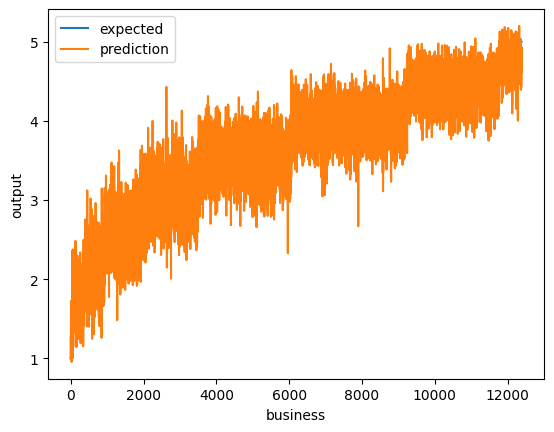

In [28]:
# Plot the chart for the best model. NOTE: best model must be manually entered.
bestModel = sigmoid_adam_pred
chart_regression(bestModel.flatten(),y_test, sort=True)

### Regression lift chart without sorting on expected output (y_test)

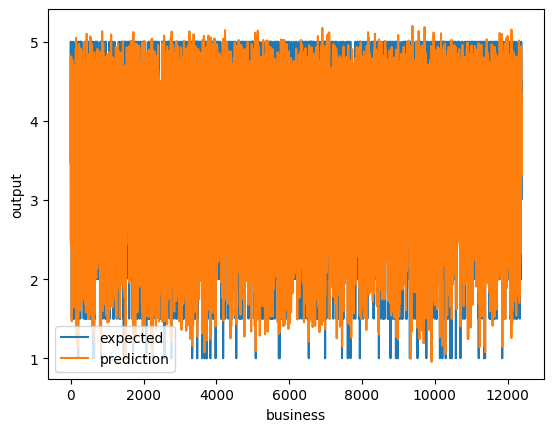

In [29]:
chart_regression(bestModel.flatten(),y_test, sort=False)

# Selecting 3-5 arbitrary businesses to predict the outcome.

In [30]:
print(len(sigmoid_adam_pred))
sigmoid_adam_pred

12384


array([[3.553534 ],
       [4.4564867],
       [3.4587889],
       ...,
       [4.081438 ],
       [3.5113058],
       [3.3586724]], dtype=float32)

In [31]:
# Split into train/test.
x_train, x_test, y_train, y_test = train_test_split(df_ready_for_sklearn[['business_id', 'name', 'categories']], df_ready_for_sklearn['stars'], test_size=0.20, random_state=42)

df_best_model_prediction = pd.DataFrame(sigmoid_adam_pred, columns = ['Prediction'])
df_x_test = pd.DataFrame(x_test).sort_index().reset_index()
df_y_test = y_test.reset_index()

result = pd.concat([df_x_test, df_y_test, df_best_model_prediction], axis = 1)

#Select 3-5 arbitrary businesses.
df_select = pd.DataFrame(result.loc[[0, 5, 10, 20, 40]])
df_select

,index,business_id,name,categories,index,stars,Prediction
0,4,MUTTqe8uqyMdBl186RmNeA,b'Tuna Bar',"Sushi Bars, Restaurants, Japanese",34295,3.5,3.553534
5,35,aCDY7vXYMs54EbYuQScsnQ,b'39 North Taproom & Grill',"American (Traditional), Sports Bars, Restauran...",12635,4.0,3.993385
10,62,9C2rpb56aQvW0ViZHK9sPw,b'Home Plate Sports Pub',"Bars, Restaurants, Sports Bars, Nightlife",20179,4.0,3.826322
20,114,VVvUBlc_WIEb8obKGq39dA,b'Four Green Fields',"Irish Pub, Bars, Restaurants, Irish, Nightlife",53153,4.0,4.023617
40,217,TGfPJHImEq6AQL9a1laxlg,b'Chick-fil-A',"Event Planning & Services, American (Tradition...",48411,2.0,1.827782
